In [2]:
# General imports
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
from pylab import cm
import warnings

warnings.filterwarnings("ignore")

# scikit-learn imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Qiskit imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

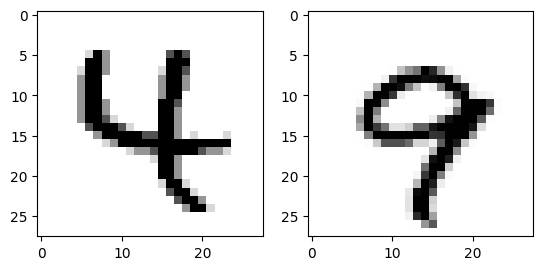

In [3]:
# Load MNIST dataset
DATA_PATH = './resources/ch3_part1.npz'
data = np.load(DATA_PATH)

sample_train = data['sample_train']
labels_train = data['labels_train']
sample_test = data['sample_test']

# Split train data
sample_train, sample_val, labels_train, labels_val = train_test_split(
    sample_train, labels_train, test_size=0.2, random_state=42)

# Visualize samples
fig = plt.figure()

LABELS = [4, 9]
num_labels = len(LABELS)
for i in range(num_labels):
    ax = fig.add_subplot(1, num_labels, i+1)
    img = sample_train[labels_train==LABELS[i]][0].reshape((28, 28))
    ax.imshow(img, cmap="Greys")

In [4]:
# Standardize
ss = StandardScaler()
sample_train = ss.fit_transform(sample_train)
sample_val = ss.transform(sample_val)
sample_test = ss.transform(sample_test)

# Reduce dimensions
N_DIM = 5
pca = PCA(n_components=N_DIM)
sample_train = pca.fit_transform(sample_train)
sample_val = pca.transform(sample_val)
sample_test = pca.transform(sample_test)

# Normalize
mms = MinMaxScaler((-1, 1))
sample_train = mms.fit_transform(sample_train)
sample_val = mms.transform(sample_val)
sample_test = mms.transform(sample_test)

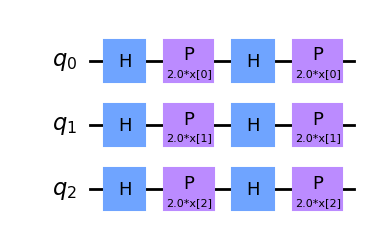

In [5]:
# 3 features, depth 2
map_z = ZFeatureMap(feature_dimension=3, reps=2)
map_z.decompose().draw('mpl')

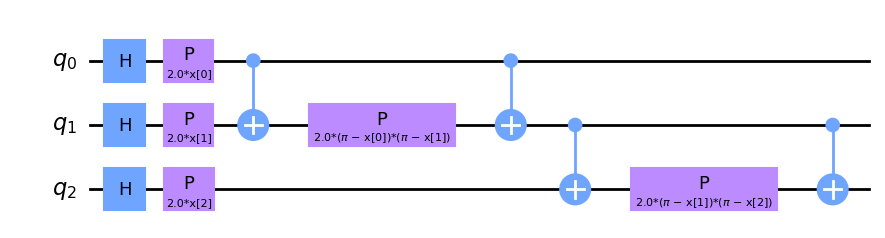

In [6]:
# 3 features, depth 1, linear entanglement
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='linear')
map_zz.decompose().draw('mpl')

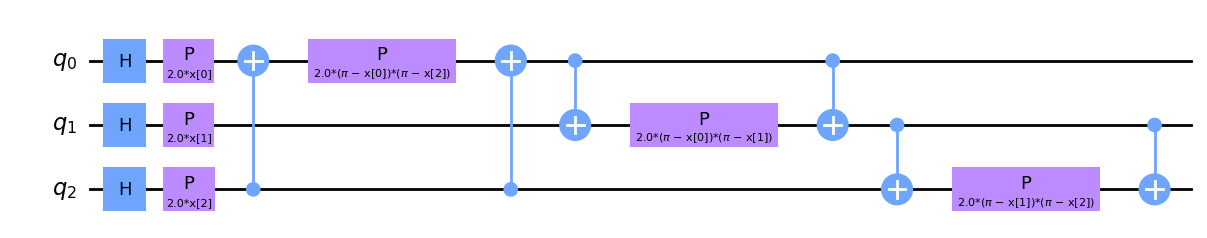

In [7]:
# 3 features, depth 1, circular entanglement
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='circular')
map_zz.decompose().draw('mpl')

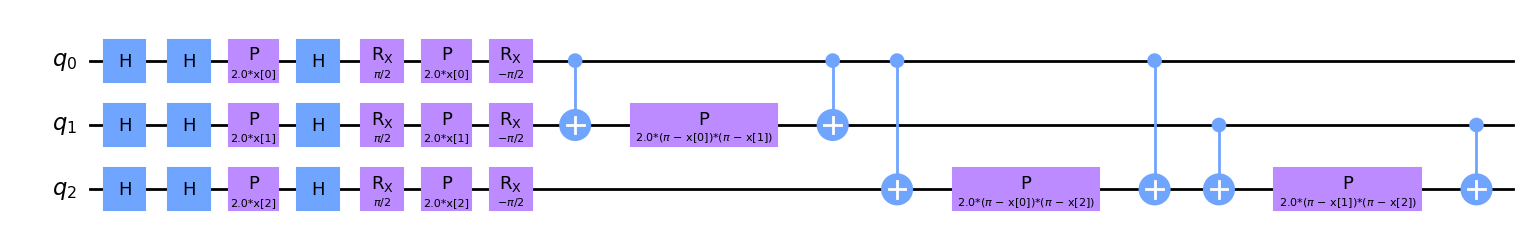

In [8]:
# 3 features, depth 1
map_pauli = PauliFeatureMap(feature_dimension=3, reps=1, paulis = ['X', 'Y', 'ZZ'])
map_pauli.decompose().draw('mpl')

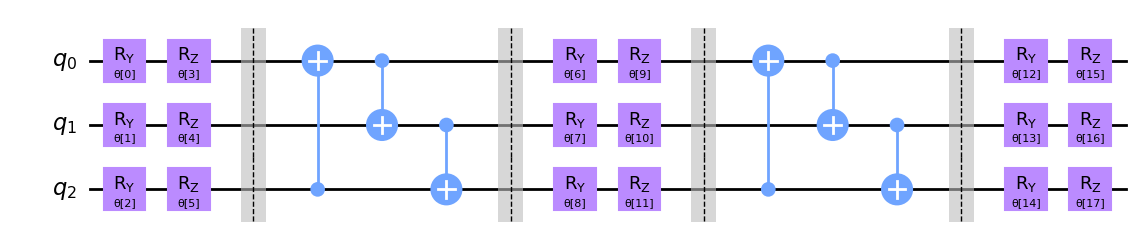

In [9]:
twolocal = TwoLocal(num_qubits=3, reps=2, rotation_blocks=['ry','rz'], 
               entanglement_blocks='cx', entanglement='circular', insert_barriers=True)
twolocal.decompose().draw('mpl')

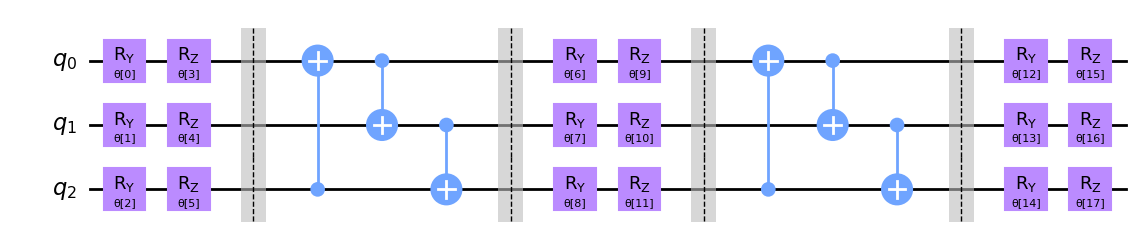

In [10]:
twolocaln = NLocal(num_qubits=3, reps=2,
               rotation_blocks=[RYGate(Parameter('a')), RZGate(Parameter('a'))], 
               entanglement_blocks=CXGate(), 
               entanglement='circular', insert_barriers=True)
twolocaln.decompose().draw('mpl')

In [11]:
print(f'First training data: {sample_train[0]}')

First training data: [-0.47556196 -0.42255763  0.3002917   0.00515026 -0.89449283]


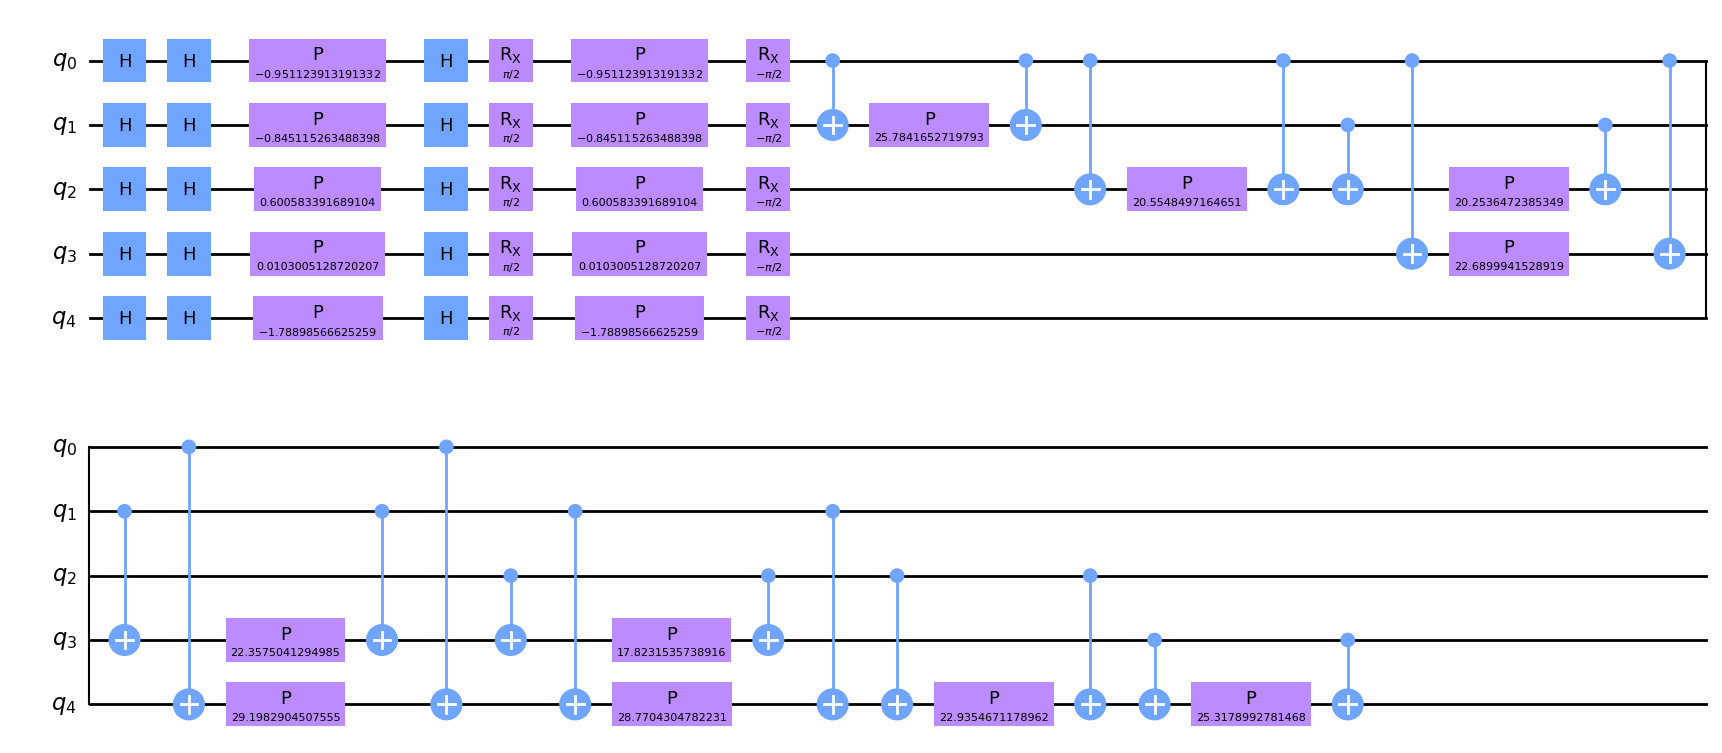

In [12]:
encode_map = PauliFeatureMap(feature_dimension=N_DIM, reps=1, paulis = ['X', 'Y', 'ZZ'])
encode_circuit = encode_map.bind_parameters(sample_train[0])
encode_circuit.decompose().draw(output='mpl')

#Challenge 3a

Construct a feature map to encode a 5-dimensionally embedded data, using 'ZZFeatureMap' with 3 repetitions, 'circular' entanglement and the rest as default.

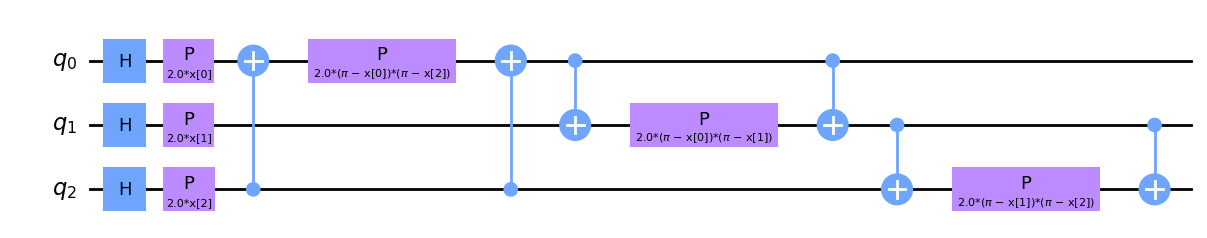

In [13]:
##############################
# Provide your code here


ex3a_fmap = ZZFeatureMap(feature_dimension=5, reps=1, entanglement='circular')
map_zz.decompose().draw('mpl')


##############################

#2.2 Quantum Kernel Estimation

In [14]:
pauli_map = PauliFeatureMap(feature_dimension=N_DIM, reps=1, paulis = ['X', 'Y', 'ZZ'])
pauli_kernel = QuantumKernel(feature_map=pauli_map, quantum_instance=Aer.get_backend('statevector_simulator'))

In [15]:
print(f'First training data : {sample_train[0]}')
print(f'Second training data: {sample_train[1]}')

First training data : [-0.47556196 -0.42255763  0.3002917   0.00515026 -0.89449283]
Second training data: [ 0.05258852 -0.67205281 -0.2819275   0.02271048 -0.38698511]


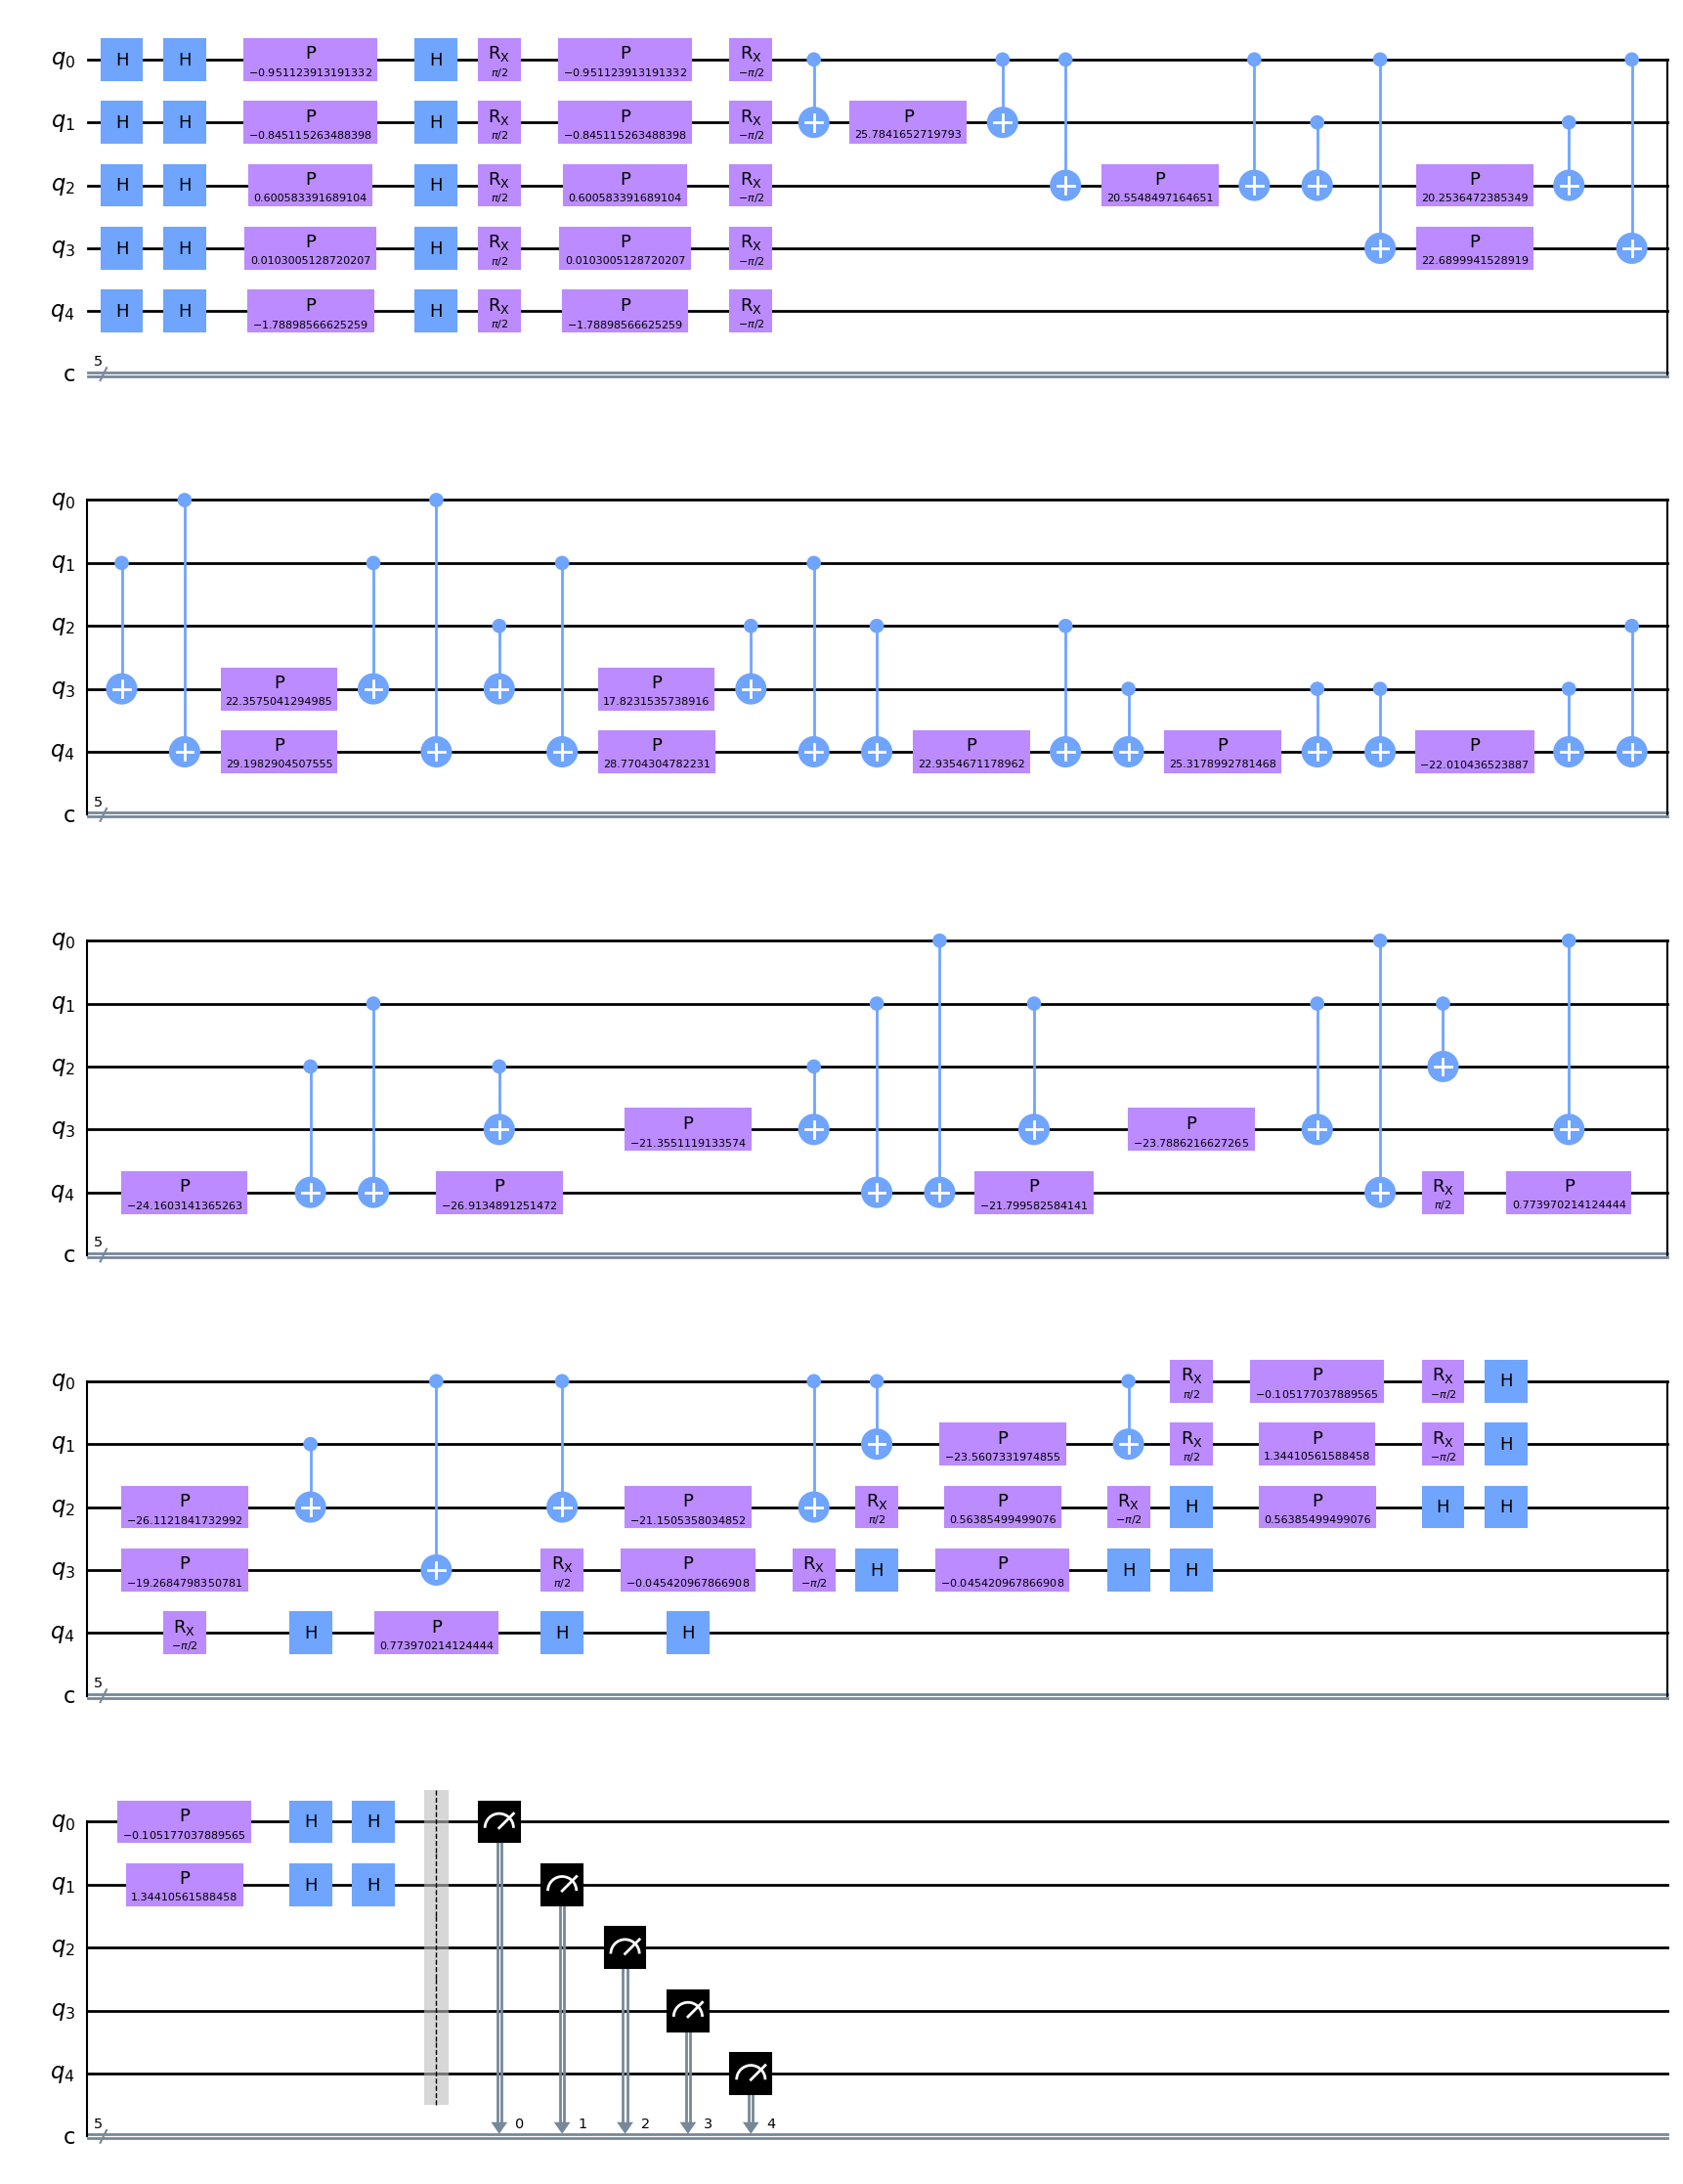

In [16]:
pauli_circuit = pauli_kernel.construct_circuit(sample_train[0], sample_train[1])
pauli_circuit.decompose().decompose().draw(output='mpl')

In [17]:
backend = Aer.get_backend('qasm_simulator')
job = execute(pauli_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(pauli_circuit)

In [18]:
print(f"Transition amplitude: {counts['0'*N_DIM]/sum(counts.values())}")

Transition amplitude: 0.028564453125


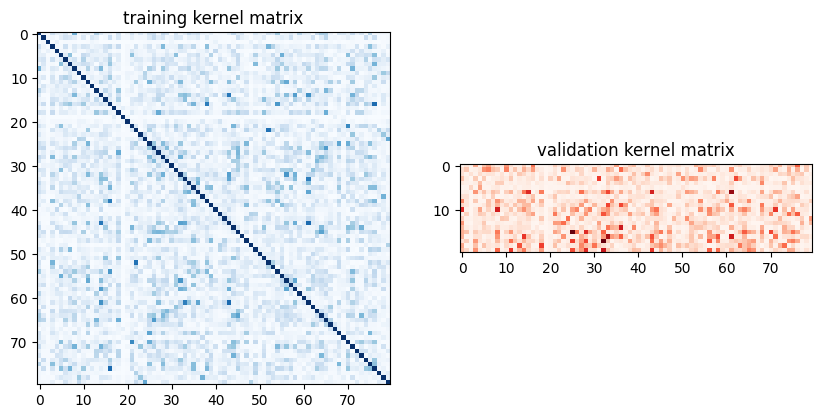

In [19]:
matrix_train = pauli_kernel.evaluate(x_vec=sample_train)
matrix_val = pauli_kernel.evaluate(x_vec=sample_val, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_val),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("validation kernel matrix")
plt.show()

#Challenge 3b

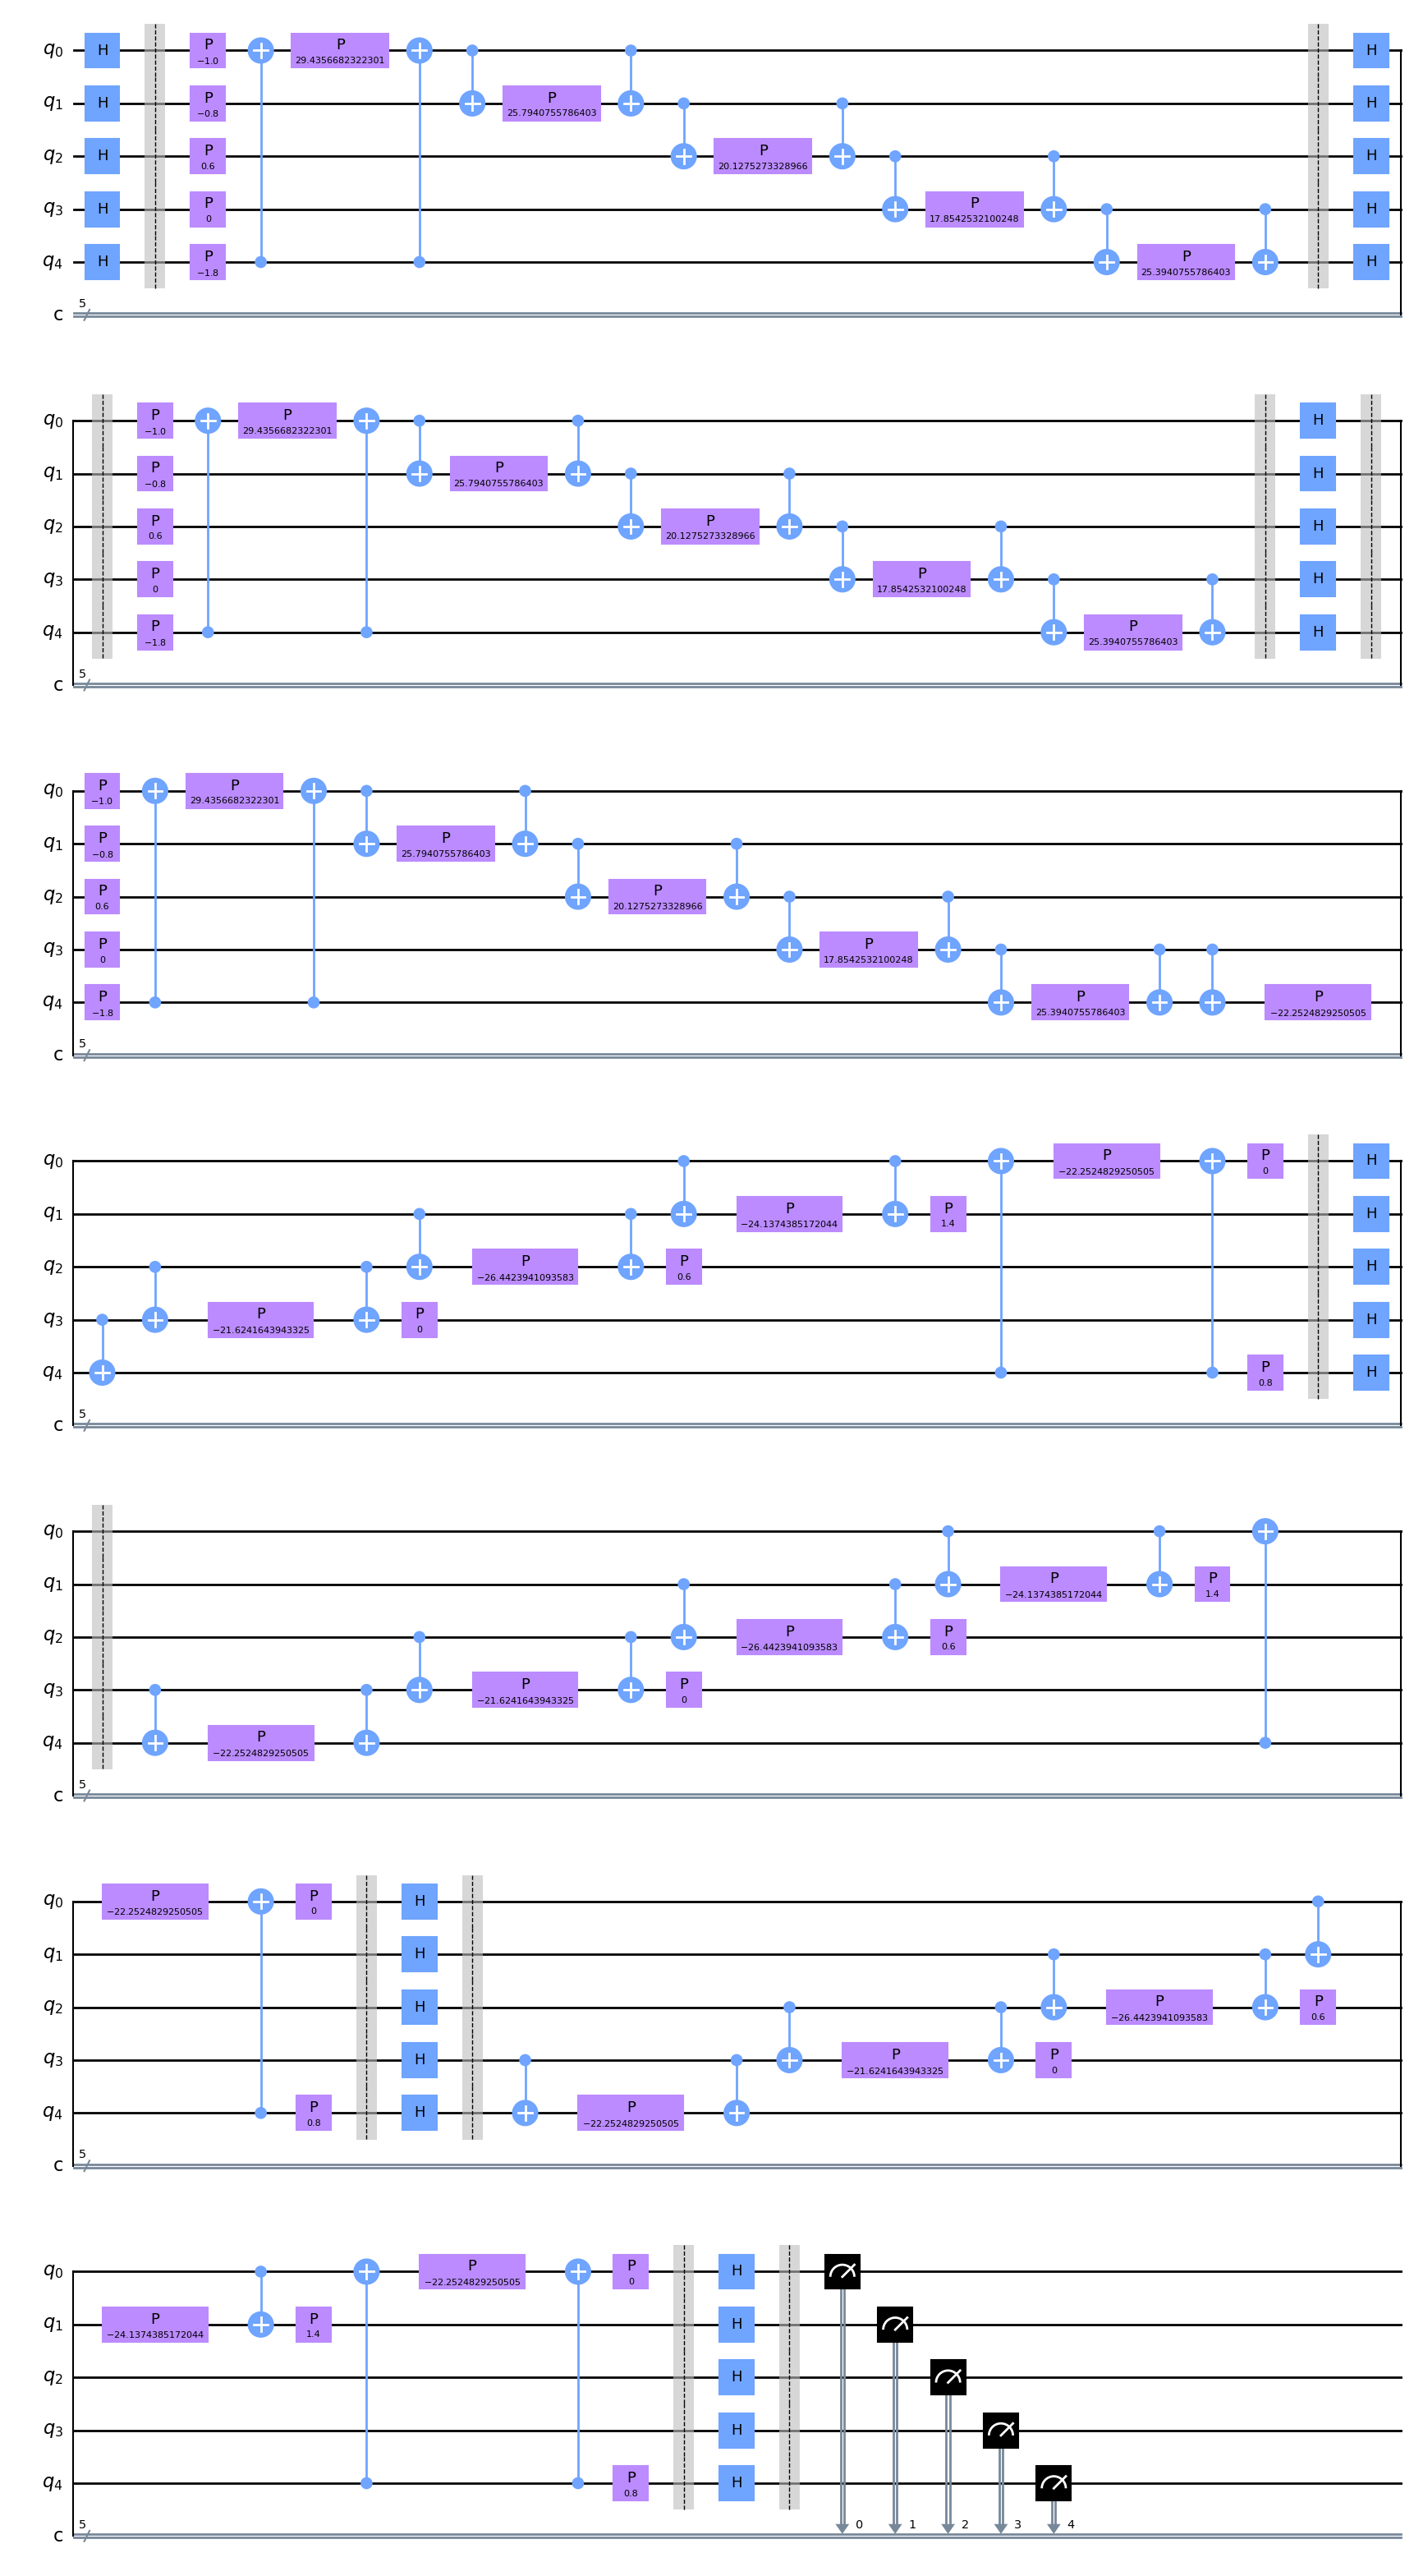

In [20]:
x = [-0.5, -0.4, 0.3, 0, -0.9]
y = [0, -0.7, -0.3, 0, -0.4]

##############################
# Provide your code here


zz_map=ZZFeatureMap(feature_dimension=5,reps=3, entanglement="circular", insert_barriers=True)
zz_kernel=QuantumKernel(feature_map=zz_map,quantum_instance=Aer.get_backend("statevector_simulator"))

#Let´s crerate and draw the circuit:

zz_circuit=zz_kernel.construct_circuit(x,y)
zz_circuit.decompose().decompose().draw(output="mpl")
#ex3b_amp = 


##############################

In [21]:
backend=Aer.get_backend("qasm_simulator")
job=execute(zz_circuit,backend,shots=8192,seed_simultor=1024, seed_transpiler=1024)
counts=job.result().get_counts(zz_circuit)

#The transition amplitude is the proportion of counts in the zero state:
#"00000" because our feature dimension is 5
ex3b_amp=counts["00000"]/sum(counts.values())
print(ex3b_amp)

0.0062255859375


In [22]:
pauli_svc = SVC(kernel='precomputed')
pauli_svc.fit(matrix_train, labels_train)
pauli_score = pauli_svc.score(matrix_val, labels_val)

print(f'Precomputed kernel classification test score: {pauli_score*100}%')

Precomputed kernel classification test score: 70.0%


#Part 2: Challenge - QSVM for 3-class classification of Fashion-MNIST

1. Data preparation

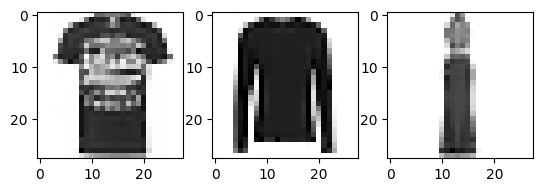

In [23]:
# Load MNIST dataset
DATA_PATH = './resources/ch3_part2.npz'
data = np.load(DATA_PATH)

sample_train = data['sample_train']
labels_train = data['labels_train']
sample_test = data['sample_test']

# Split train data
sample_train, sample_val, labels_train, labels_val = train_test_split(
    sample_train, labels_train, test_size=0.2, random_state=42)

# Visualize samples
fig = plt.figure()

LABELS = [0, 2, 3]
num_labels = len(LABELS)
for i in range(num_labels):
    ax = fig.add_subplot(1, num_labels, i+1)
    img = sample_train[labels_train==LABELS[i]][0].reshape((28, 28))
    ax.imshow(img, cmap="Greys")

In [24]:
# Standardize
standard_scaler = StandardScaler()
sample_train = standard_scaler.fit_transform(sample_train)
sample_val = standard_scaler.transform(sample_val)
sample_test = standard_scaler.transform(sample_test)

# Reduce dimensions
N_DIM = 5
pca = PCA(n_components=N_DIM)
sample_train = pca.fit_transform(sample_train)
sample_val = pca.transform(sample_val)
sample_test = pca.transform(sample_test)

# Normalize
min_max_scaler = MinMaxScaler((-1, 1))
sample_train = min_max_scaler.fit_transform(sample_train)
sample_val = min_max_scaler.transform(sample_val)
sample_test = min_max_scaler.transform(sample_test)

#2. Modeling

2.1: Label 0 vs Rest

In [25]:
labels_train_0 = np.where(labels_train==0, 1, 0)
labels_val_0 = np.where(labels_val==0, 1, 0)

print(f'Original validation labels:      {labels_val}')
print(f'Validation labels for 0 vs Rest: {labels_val_0}')

Original validation labels:      [3 3 2 0 3 0 3 2 3 2 2 3 2 2 2 3 0 2 3 3]
Validation labels for 0 vs Rest: [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


In [26]:
pauli_map_0 = PauliFeatureMap(feature_dimension=N_DIM, reps=2, paulis = ['X', 'Y', 'ZZ'])
pauli_kernel_0 = QuantumKernel(feature_map=pauli_map_0, quantum_instance=Aer.get_backend('statevector_simulator'))

pauli_svc_0 = SVC(kernel='precomputed', probability=True)

matrix_train_0 = pauli_kernel_0.evaluate(x_vec=sample_train)
pauli_svc_0.fit(matrix_train_0, labels_train_0)

matrix_val_0 = pauli_kernel_0.evaluate(x_vec=sample_val, y_vec=sample_train)
pauli_score_0 = pauli_svc_0.score(matrix_val_0, labels_val_0)
print(f'Accuracy of discriminating between label 0 and others: {pauli_score_0*100}%')

Accuracy of discriminating between label 0 and others: 75.0%


In [27]:
matrix_test_0 = pauli_kernel_0.evaluate(x_vec=sample_test, y_vec=sample_train)
pred_0 = pauli_svc_0.predict_proba(matrix_test_0)[:, 1]
print(f'Probability of label 0: {np.round(pred_0, 2)}')

Probability of label 0: [0.31 0.31 0.28 0.38 0.26 0.3  0.27 0.27 0.32 0.4  0.35 0.3  0.26 0.28
 0.36 0.4  0.34 0.38 0.32 0.26]


#2.2: Label 2 vs Rest

In [28]:
##############################
# Provide your code here

labels_train_2 = np.where(labels_train==2, 1, 0)
labels_val_2 = np.where(labels_val==2, 1, 0)

print(f'Original validation labels:      {labels_val}')
print(f'Validation labels for 2 vs Rest: {labels_val_2}')


pauli_map_2 = PauliFeatureMap(feature_dimension=N_DIM, reps=2, paulis = ['X', 'Y', 'ZZ'])
pauli_kernel_2 = QuantumKernel(feature_map=pauli_map_2, quantum_instance=Aer.get_backend('statevector_simulator'))

pauli_svc_2 = SVC(kernel='precomputed', probability=True)

matrix_train_2 = pauli_kernel_2.evaluate(x_vec=sample_train)
pauli_svc_2.fit(matrix_train_2, labels_train_2)

matrix_val_2 = pauli_kernel_2.evaluate(x_vec=sample_val, y_vec=sample_train)
pauli_score_2 = pauli_svc_2.score(matrix_val_2, labels_val_2)
print(f'Accuracy of discriminating between label 2 and others: {pauli_score_2*100}%')

matrix_test_2 = pauli_kernel_2.evaluate(x_vec=sample_test, y_vec=sample_train)
pred_2 = pauli_svc_2.predict_proba(matrix_test_2)[:, 1]
print(f'Probability of label 2: {np.round(pred_2, 2)}') 


##############################

Original validation labels:      [3 3 2 0 3 0 3 2 3 2 2 3 2 2 2 3 0 2 3 3]
Validation labels for 2 vs Rest: [0 0 1 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0]
Accuracy of discriminating between label 2 and others: 75.0%
Probability of label 2: [0.33 0.14 0.1  0.15 0.28 0.35 0.34 0.47 0.13 0.41 0.09 0.47 0.78 0.71
 0.24 0.25 0.11 0.11 0.33 0.6 ]


#2.3 Label 3 vs Rest

In [29]:
##############################
# Provide your code here


labels_train_3 = np.where(labels_train==3, 1, 0)
labels_val_3 = np.where(labels_val==3, 1, 0)

print(f'Original validation labels:      {labels_val}')
print(f'Validation labels for 2 vs Rest: {labels_val_3}')

pauli_map_3 = PauliFeatureMap(feature_dimension=N_DIM, reps=2, paulis = ['X', 'Y', 'ZZ'])
pauli_kernel_3 = QuantumKernel(feature_map=pauli_map_3, quantum_instance=Aer.get_backend('statevector_simulator'))

pauli_svc_3 = SVC(kernel='precomputed', probability=True)

matrix_train_3 = pauli_kernel_3.evaluate(x_vec=sample_train)
pauli_svc_3.fit(matrix_train_3, labels_train_3)

matrix_val_3 = pauli_kernel_3.evaluate(x_vec=sample_val, y_vec=sample_train)
pauli_score_3 = pauli_svc_3.score(matrix_val_3, labels_val_3)
print(f'Accuracy of discriminating between label 3 and others: {pauli_score_3*100}%')

matrix_test_3 = pauli_kernel_3.evaluate(x_vec=sample_test, y_vec=sample_train)
pred_3 = pauli_svc_3.predict_proba(matrix_test_3)[:, 1]
print(f'Probability of label 3: {np.round(pred_3, 2)}') 
##############################

Original validation labels:      [3 3 2 0 3 0 3 2 3 2 2 3 2 2 2 3 0 2 3 3]
Validation labels for 2 vs Rest: [1 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1]
Accuracy of discriminating between label 3 and others: 65.0%
Probability of label 3: [0.19 0.39 0.52 0.39 0.52 0.35 0.28 0.26 0.37 0.15 0.42 0.23 0.17 0.19
 0.24 0.22 0.56 0.21 0.38 0.22]


In [30]:
sample_pred = np.load('./resources/ch3_part2_sub.npy')
print(f'Sample prediction: {sample_pred}')

Sample prediction: [0 0 0 0 0 0 2 2 2 2 2 2 3 3 3 3 3 3 3 3]


In [31]:
pred_2_ex = np.array([0.7])
pred_3_ex = np.array([0.2])

pred_test_ex = np.where((pred_2_ex > pred_3_ex), 2, 3)
print(f'Prediction: {pred_test_ex}')

Prediction: [2]


In [32]:
pred_2_ex = np.array([0.7, 0.1])
pred_3_ex = np.array([0.2, 0.6])

pred_test_ex = np.where((pred_2_ex > pred_3_ex), 2, 3)
print(f'Prediction: {pred_test_ex}')

Prediction: [2 3]


In [37]:
##############################
# Provide your code here

pred_test = np.where((pred_0 > pred_2) & (pred_0 > pred_3),0, np.where(pred_2 > pred_3, 2, 3))
print(f'Prediction: {pred_test}')

##############################

Prediction: [2 3 3 3 3 2 2 2 3 2 3 2 2 2 0 0 3 0 3 2]
